## Setting

In [1]:
# 정의 함수 load
from utils.data import *
from utils.model import *
from utils.metric import *
from utils.analysis import *

[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Dataset List: dt_config/datasets
dt_config = dataset_config()
datasets= list(dt_config.keys())

# print('Dataset List:')
# print(datasets)

In [3]:
# Dataset Load: dt_dict
# datasets = [
#     'region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 
#     'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'
# ]

dt_dict = {}
for ds in datasets:
    data, df, cfg = load_and_prepare_dataset(dt_config, config_name=ds, seed=1127)
    dt_dict[ds] = {
        'data': data,
        'df': df,
        'cfg': cfg
    }

# Check Dataset: Train/Val/Test 민감속성 비율 동일하게 설정
# print_sensitive_attr_distribution(dt_dict['nba_p']['data'])

Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 43962, sens=1: 23834
--------------------------------------------------
Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 34308, sens=1: 33488
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 47338, sens=1: 19231
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 34125, sens=1: 32444
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 296, sens=1: 107
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 29

c:\Users\user\workspace_sy\DAF-GNN\utils\data.py:166: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(indices, values, shape)


[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------


In [4]:
# Evluate Dataset: eval_dt_df
eval_dt = {}
ev_dt_list = ['region_job_r', 'region_job_2_g', 'nba_m', 'german_g']
for ds in ev_dt_list:
    data = dt_dict[ds]['data']
    features = data.x
    edge_index = data.edge_index
    sens = data.sensitive_attr

    eval_dt[ds] = {
        "Homophily Ratio": homophily_ratio(edge_index, sens),
        "Assortativity Coefficient": assortativity_coefficient(data),
        "Local Neighborhood Fairness": local_neighborhood_fairness(edge_index, sens),
        "Degree Balance": degree_balance(edge_index, sens),
        'Structural Bias': structural_bias(features, edge_index, sens)
    }

eval_dt_df = pd.DataFrame(eval_dt).T
print(eval_dt_df)

                Homophily Ratio  Assortativity Coefficient  \
region_job_r           0.953181                   0.901644   
region_job_2_g         0.488935                  -0.022346   
nba_m                  0.744589                   0.232719   
german_g               0.809190                   0.536039   

                Local Neighborhood Fairness  Degree Balance  Structural Bias  
region_job_r                       0.404528        3.283391         0.035817  
region_job_2_g                     0.193029        0.353691         0.032298  
nba_m                              0.166268       13.442473         0.076014  
german_g                           0.251152        4.291912         0.174177  


In [5]:
# Experiments Setting
runs=5
epochs=500

cuda=torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
print(f"Using device: {device}")

seed=1127
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

# 공통
lr=0.001
weight_decay=1e-5
patience = 50

# model mapping
model_map = {
    'FnRGNN': lambda data: FnRGNN(nfeat=data.x.size(1), hidden_dim=64, dropout=0.5, lm=3, gm=1, ld=1, mmd_sample=500, lr=lr, weight_decay=weight_decay),
    'FairGNN': lambda data: FairGNN(nfeat=data.x.size(1), hidden_dim=64, model='GCN', dropout=0.5, hidden=128, alpha=4, beta=0.01, lr=lr, weight_decay=weight_decay),
    'FMP': lambda data: FMP(data, num_hidden=64, num_layers=5, num_gnn_layer=2, lambda1=3, lambda2=3, dropout=0.5, num_classes=1, L2=True, cached=False),
    'GMMD': lambda data: GMMD(in_channels=data.x.size(1), hidden_channels=64),
    'EDITS': lambda data: EDITS(nfeat=data.x.size(1), node_num=data.x.size(0), nfeat_out=int(data.x.size(0) / 10), adj_lambda=1e-1, layer_threshold=2, dropout=0.2, lr=lr, weight_decay=weight_decay),
    'MLPRegressor': lambda data: MLPRegressor(in_dim=data.x.size(1), hidden_dim=64),
    'GCNRegressor': lambda data: GCNRegressor(in_dim=data.x.size(1), hidden_dim=64),
    'GATRegressor': lambda data: GATRegressor(in_dim=data.x.size(1), hidden_dim=64, heads=1),
    'GraphSAGERegressor': lambda data: GraphSAGERegressor(in_dim=data.x.size(1), hidden_dim=64),
    'GINRegressor': lambda data: GINRegressor(in_dim=data.x.size(1), hidden_dim=64),
}


Using device: cuda:0


In [6]:
# import subprocess

# try:
#     result = subprocess.check_output(['nvidia-smi']).decode()
#     print(result)
# except FileNotFoundError:
#     print("nvidia-smi가 설치되어 있지 않거나 NVIDIA GPU가 없습니다.")


## ALL

### ALL Training

In [17]:
# All Training
tr_md_list = [
    'FairGNN', 'FMP', 'GMMD', 'GCNRegressor', 
    # 'EDITS',
    # 'MLPRegressor', 'GATRegressor', 'GraphSAGERegressor', 'GINRegressor', 
    ]
tr_dt_list = [
    # 'region_job_g', 
    'region_job_2_g',
    # 'region_job_r', 'region_job_2_r', 
    # 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'
    ]

# FairGNN Sensitive Model
for ds in tr_dt_list:
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    print(f'Train FairGNN Sensitive Model dataset from {ds}')
    
    fair_sen_model = GCN(nfeat=data.x.shape[1], nhid=128, nclass=1, dropout=0.5).to(device)
    fair_optimizer = optim.Adam(fair_sen_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    best_mse = float('inf')
    best_result = {}

    for epoch in range(epochs + 1):    
        fair_sen_model.train()
        fair_optimizer.zero_grad()
        output = fair_sen_model(data.x, data.edge_index)
        loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
        loss.backward()
        fair_optimizer.step()

        fair_fastmode=False
        if not fair_fastmode:
            fair_sen_model.eval()
            with torch.no_grad():
                output = fair_sen_model(data.x, data.edge_index)
                mse_val = mean_squared_error(data.sensitive_attr[data.idx_val].cpu().numpy(), output[data.idx_val].cpu().numpy())
                mse_test = mean_squared_error(data.sensitive_attr[data.idx_test].cpu().numpy(), output[data.idx_test].cpu().numpy())

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}] Test set results:",
                f"mse_val={mse_val:.4f}, mse_test={mse_test:.4f}")

            if mse_val < best_mse:
                best_mse = mse_val
                best_result = {'mse': mse_test}
                torch.save(fair_sen_model.state_dict(), f"./logs/checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}")

    print(f"The best MSE of estimator: {best_result['mse']:.4f}")
    print("Optimization Finished!")

# All Model
for ds in tr_dt_list:
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    for md in tr_md_list:
        print(f'Train {md} dataset from {ds}')
        os.makedirs(f'./model/{md}', exist_ok=True) 
        model_path = f'./model/{md}/{dn}_md.pth'
        
        for run in range(runs + 1):
            model = model_map[md](data).to(device)

            if md not in ['FairGNN', 'EDITS']:
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = torch.nn.MSELoss()
            elif md == 'FairGNN':
                try:
                    model.estimator.load_state_dict(torch.load( f"./logs/checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}", map_location=torch.device(device) ))
                except Exception as e:
                    print(f"Checkpoint load failed: {e}")
            elif md == 'EDITS':
                features = data.x.to(device).to(torch.float32)
                labels = data.y.to(device).to(torch.float32)
                sens = data.sensitive_attr.to(device).to(torch.float32)

                adj = data.adj
                if isinstance(adj, torch.Tensor):
                    adj = adj.to(device).to(torch.float32)
                else:
                    adj = torch.FloatTensor(adj.toarray()).to(device).to(torch.float32)

                idx_train = data.idx_train
                idx_val = data.idx_val
                idx_test = data.idx_test
            
            best_score = float('inf')
            best_model_state = None
            patience_counter = 0

            for epoch in range(epochs + 1):
                if md == 'FairGNN':
                    model.optimize(data)
                elif md == 'EDITS':
                    lr_adj = 0.001 if epoch > 400 else 0.003
                    model.train()
                    model.optimize(adj, features, idx_train, sens, epoch, lr_adj)
                elif md == 'GMMD':
                    model.train()
                    optimizer.zero_grad()
                    pred, mmd_loss = model(data)
                    pred = pred.squeeze()
                    loss = mmd_loss + criterion(pred[data.idx_train], data.y[data.idx_train].squeeze())
                    loss.backward()
                    optimizer.step()
                else:
                    model.train()
                    optimizer.zero_grad()
                    output = model(data)
                    if md == 'FMP':
                        loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
                    else:
                        loss = criterion(output[data.idx_train].unsqueeze(1), data.y[data.idx_train].unsqueeze(1))
                    loss.backward()
                    optimizer.step()

                # validation
                model.eval()
                with torch.no_grad():
                    if md == 'EDITS':
                        adj_sparse = to_scipy_sparse_matrix(data.edge_index).tocoo()
                        adj = sparse_mx_to_torch_sparse_tensor(adj_sparse).to(device)
                        features = data.x
                        if not hasattr(model.adj_renew, "estimator"):
                            model.adj_renew.fit(adj, lr=0.003)
                        output = model(adj, features)[0] 
                    elif md in ['FairGNN', 'GMMD']:
                        output, _ = model(data)
                    else:
                        output = model(data)

                    y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr
                    mse_val = mean_squared_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                    mae_val = mean_absolute_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                    mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                    dist_val = group_distribution_metrics(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())
                    
                    val_score = mse_val
                    if val_score < best_score:
                        best_mse = val_score
                        best_model_state = copy.deepcopy(model.state_dict())
                        torch.save(best_model_state, model_path)
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f'Early stopping at epoch {epoch} | Best Val score: {best_score:.4f}')
                        break
                        
                    
                    if epoch % 100 == 0:
                        print(f"[{md}] Run {run}, Epoch {epoch} | "
                            f"Val MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, \n"
                            f"MSE Diff: {mse_diff:.2f}, MAE Diff: {mae_diff:.2f}, MEAN Diff: {mean_diff:.2f}, Var Diff: {var_diff:.2f}, "
                            f"Wasserstein Diff: {dist_val['wasserstein']:.2f}, JS Diff: {dist_val['js']:.2f}"
                        )

Train FairGNN Sensitive Model dataset from region_job_2_g
Epoch [0] Test set results: mse_val=0.4971, mse_test=0.4954
Epoch [50] Test set results: mse_val=0.9217, mse_test=0.9186
Epoch [100] Test set results: mse_val=0.9507, mse_test=0.9493
Epoch [150] Test set results: mse_val=0.9787, mse_test=0.9768
Epoch [200] Test set results: mse_val=0.9917, mse_test=0.9891
Epoch [250] Test set results: mse_val=1.0008, mse_test=0.9972
Epoch [300] Test set results: mse_val=0.9966, mse_test=0.9924
Epoch [350] Test set results: mse_val=1.0032, mse_test=0.9976
Epoch [400] Test set results: mse_val=1.0097, mse_test=1.0035
Epoch [450] Test set results: mse_val=1.0184, mse_test=1.0106
Epoch [500] Test set results: mse_val=1.0206, mse_test=1.0122
The best MSE of estimator: 0.4954
Optimization Finished!
Train FairGNN dataset from region_job_2_g
[FairGNN] Run 0, Epoch 0 | Val MSE: 0.84, MAE: 0.83, 
MSE Diff: 0.04, MAE Diff: 0.00, MEAN Diff: 0.01, Var Diff: 0.00, Wasserstein Diff: 0.03, JS Diff: 0.01
[FairGN

### ALL Testing

In [26]:
# Testing
ts_md_list = [
    'FnRGNN', 'FairGNN', 'FMP', 'GMMD', 'EDITS', 'GCNRegressor', 
    # 'MLPRegressor', 'GATRegressor', 'GraphSAGERegressor', 'GINRegressor'
    ]
ts_dt_list = [
    # 'region_job_g', 
    'region_job_2_g',
    'region_job_r', 
    # 'region_job_2_r', 
    # 'nba_p', 
    'nba_m', 'german_g', 
    # 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'
    ]

ts_results = {}
for ds in ts_dt_list:
    print(f'\n>>> Evaluating Dataset: {ds}')
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    for md in ts_md_list:
        print(f'Test {md} dataset from {ds}')
        if md == 'FnRGNN':
            model_path = f'./model/FnRGNN_only/{dn}_md.pth'
        else:
            model_path = f'./model/{md}/{dn}_md.pth'

        if not os.path.exists(model_path):
            print(f"[{md} - {ds}] 모델 파일 없음: {model_path}")
            ts_results.setdefault(md, {})[ds] = None
            continue

        result = []
        for run in range(runs + 1):
            try:
                if md == 'FnRGNN':
                    import json
                    config_path = f"./logs/best_configs/{ds}_best_mse.json"
                    with open(config_path, "r") as f:
                        best_mse_result = json.load(f)
                    params = best_mse_result['params']
                    model = FnRGNN(
                        nfeat=data.x.size(1),
                        hidden_dim=params['hidden_dim'],
                        dropout=params['dropout'],
                        lm=params['lambda2'],
                        gm=params['gamma'],
                        ld=params['lambda_dist'],
                        mmd_sample=500,
                        lr=params['lr'],
                        weight_decay=params['weight_decay']
                    ).to(device)
                else:
                    model = model_map[md](data).to(device)

                state_dict = torch.load(model_path)
                state_dict.pop("adj_renew.estimator.estimated_adj", None)  # EDITS 대응
                model.load_state_dict(state_dict, strict=False)

                model.eval()
                with torch.no_grad():
                    if md == 'EDITS':
                        adj_sparse = to_scipy_sparse_matrix(data.edge_index).tocoo()
                        adj = sparse_mx_to_torch_sparse_tensor(adj_sparse).to(device)
                        features = data.x
                        if not hasattr(model.adj_renew, "estimator"):
                            model.adj_renew.fit(adj, lr=0.003)
                        output = model(adj, features)[0]
                    elif md in ['FnRGNN', 'FairGNN', 'GMMD']:
                        output, _ = model(data)
                    else:
                        output = model(data)

                    y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
                    mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                    mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                    mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(
                        output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu()
                    )
                    dist_test = group_distribution_metrics(
                        y_true[idx_test].cpu().numpy().squeeze(),
                        output[idx_test].cpu().numpy().squeeze(),
                        sensitive_attr[idx_test].cpu().numpy()
                    )

                result.append([mse_test, mse_diff, mae_test, mae_diff, mean_diff, var_diff,
                               dist_test['wasserstein'], dist_test['js'], dist_test['kl'], dist_test['ks'], dist_test['cvm'], dist_test['tv']])
            except Exception as e:
                print(f"[{md} - {ds} - Run {run}] 오류 발생: {e}")
                result.append(None)

        ts_results.setdefault(md, {})[ds] = result



>>> Evaluating Dataset: region_job_2_g
Test FnRGNN dataset from region_job_2_g
Test FairGNN dataset from region_job_2_g
Test FMP dataset from region_job_2_g
Test GMMD dataset from region_job_2_g
Test EDITS dataset from region_job_2_g
[EDITS - region_job_2_g] 모델 파일 없음: ./model/EDITS/Pokec_n_Gender_md.pth
Test GCNRegressor dataset from region_job_2_g

>>> Evaluating Dataset: region_job_r
Test FnRGNN dataset from region_job_r
Test FairGNN dataset from region_job_r
Test FMP dataset from region_job_r
Test GMMD dataset from region_job_r
Test EDITS dataset from region_job_r
[EDITS - region_job_r] 모델 파일 없음: ./model/EDITS/Pokec_z_Region_md.pth
Test GCNRegressor dataset from region_job_r

>>> Evaluating Dataset: nba_m
Test FnRGNN dataset from nba_m
Test FairGNN dataset from nba_m
Test FMP dataset from nba_m
Test GMMD dataset from nba_m
Test EDITS dataset from nba_m
Test GCNRegressor dataset from nba_m

>>> Evaluating Dataset: german_g
Test FnRGNN dataset from german_g
Test FairGNN dataset from 

In [27]:
# Results Check
metric_names = ['MSE', 'MSE Gap',  'MAE', 'MAE Gap', 'Mean Gap', 'Var Gap', 'WD', 'JSD', 'KL', 'KS', 'CVM', 'TV']

for md in ts_md_list:
    md_results = ts_results[md]

    summary_table = {}
    for dataset, runs_rst in md_results.items():
        if runs_rst is None:
            continue
        valid_runs = [r for r in runs_rst if r is not None]
        if not valid_runs:
            continue

        arr = np.array(valid_runs)
        means = np.mean(arr, axis=0)
        stds = np.std(arr, axis=0)

        # summary_table[dataset] = [
        #     f"{mean:.4f} ± {std:.4f}" for mean, std in zip(means, stds)
        # ]
        summary_table[dataset] = [
            f"{mean:.4f}" for mean, std in zip(means, stds)
        ]

    df_summary = pd.DataFrame(summary_table, index=metric_names)
    globals()[f'df_{md}_summary'] = df_summary

selected_metrics = ['MSE', 'MAE', 'Mean Gap', 'Var Gap', 'WD']
selected_dt_list = ts_dt_list
selected_md_list = ['GCNRegressor', 'FairGNN', 'FMP', 'GMMD', 'EDITS', 'FnRGNN']

all_tables = {}
for ds in selected_dt_list:
    result_table = {}
    for md in selected_md_list:
        df = globals().get(f'df_{md}_summary')
        if df is not None:
            if isinstance(df.index, pd.Index):
                filtered_df = df.loc[df.index.intersection(selected_metrics)]
                if ds in filtered_df.columns:
                    result_table[md] = filtered_df[ds]
    if result_table:
        df_combined = pd.DataFrame(result_table)
        df_combined.index.name = "Metric"
        all_tables[ds] = df_combined

        print(f'{ds} Results:')
        print(df_combined)


region_job_2_g Results:
         GCNRegressor FairGNN     FMP    GMMD  FnRGNN
Metric                                               
MSE            0.4837  0.5877  0.4857  0.0301  0.0511
MAE            0.5206  0.6427  0.6217  0.1140  0.1557
Mean Gap       0.0236  0.0064  0.0232  0.0437  0.0133
Var Gap        0.0011  0.0156  0.0012  0.0242  0.0003
WD             0.0181  0.0312  0.0143  0.0107  0.0018
region_job_r Results:
         GCNRegressor FairGNN     FMP    GMMD  FnRGNN
Metric                                               
MSE            0.4676  0.6921  0.3178  0.0342  0.0622
MAE            0.5169  0.7052  0.4986  0.1247  0.1829
Mean Gap       0.0602  0.0416  0.0269  0.0747  0.0171
Var Gap        0.0628  0.0392  0.0026  0.0150  0.0046
WD             0.0206  0.0055  0.0063  0.0028  0.0057
nba_m Results:
         GCNRegressor FairGNN     FMP    GMMD     EDITS  FnRGNN
Metric                                                         
MSE            5.3053  1.1417  1.0001  0.3496  746.2766

In [22]:
# latex 테이블 생성
df_latex = all_tables['region_job_2_g']
df_latex.index.name = 'Metrics'
df_latex = df_latex.reset_index()
df_latex.rename(columns={'GCNRegressor': 'GCN'}, inplace=True)

# LaTeX 테이블로 변환
print(df_latex.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{llllll}
\toprule
Metrics & GCN & FairGNN & FMP & GMMD & FnRGNN \\
\midrule
MSE & 0.4837 & 0.5877 & 0.4857 & 0.0301 & 0.0511 \\
MAE & 0.5206 & 0.6427 & 0.6217 & 0.1140 & 0.1557 \\
Mean Gap & 0.0236 & 0.0064 & 0.0232 & 0.0437 & 0.0133 \\
Var Gap & 0.0011 & 0.0156 & 0.0012 & 0.0242 & 0.0003 \\
WD & 0.0181 & 0.0312 & 0.0143 & 0.0107 & 0.0018 \\
\bottomrule
\end{tabular}



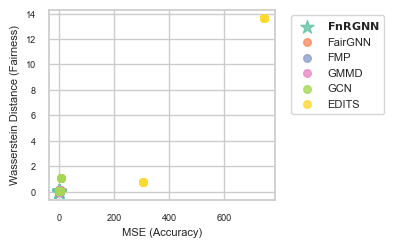

<Figure size 640x480 with 0 Axes>

In [33]:
# 결과 시각화
selected_md_list = [
    "FnRGNN",
    "FairGNN", "FMP", "GMMD", 
    "GCNRegressor", "EDITS", 
    ]
selected_dt_list = [
    'nba_m', 'german_g', 'region_job_r',  'region_job_2_g',
    # 'nba_p', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e',
    # 'region_job_2_r', 'region_job_g',
    ]
legend_names = {
    'GCNRegressor': 'GCN',
    'FairGNN': 'FairGNN',
    'FMP': 'FMP',
    'GMMD': 'GMMD',
    'EDITS': 'EDITS',
    'FnRGNN': r'$\mathbf{FnRGNN}$'  # LaTeX 강조
}
markers = {
    'GCNRegressor': 'o',
    'FairGNN': 'o',
    'FMP': 'o',
    'GMMD': 'o',
    'EDITS': 'o',
    'FnRGNN': '*'  # 또는 'x'
}

sns.set(style="whitegrid", font_scale=0.6)
palette = sns.color_palette("Set2", len(selected_md_list))
model_colors = {md: color for md, color in zip(selected_md_list, palette)}
plt.figure(figsize=(4, 2.5))  # 논문용 크기

scatter_data = []
for md in selected_md_list:
    for dt in selected_dt_list:
        if md in ts_results and dt in ts_results[md] and ts_results[md][dt] is not None:
            for r in ts_results[md][dt]:
                if r is not None:
                    mse = r[0]
                    wd = r[6]
                    plt.scatter(
                        mse, wd,
                        color=model_colors[md],
                        marker=markers.get(md, 'o'),
                        label=legend_names.get(md, md),
                        alpha=0.8 if md == 'FnRGNN' else 0.8,
                        s=100 if md == 'FnRGNN' else 30
                    )
                    scatter_data.append(legend_names.get(md, md))

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.xlabel('MSE (Accuracy)', size=8)
plt.ylabel('Wasserstein Distance (Fairness)', size=8)
# plt.xlim(-0.1, 2.3)
# plt.ylim(-0.01, 0.2)
plt.tight_layout()
plt.show()

plt.savefig("exp_results.pdf", bbox_inches='tight')

## FnR

### FnR Training

In [8]:
# FnRGNN Training
FnR_dt_list = [
    # 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e',
    # 'region_job_r', 'region_job_2_r',
    'region_job_g', 'region_job_2_g',
]

all_logs = {}  # 데이터셋별 전체 로그 저장용

for ds in FnR_dt_list:
    data = dt_dict[ds]['data'].to(device)
    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    print(f'\n===> Training FnRGNN on dataset: {ds}')
    os.makedirs('./model/FnRGNN_only', exist_ok=True)
    model_path = f'./model/FnRGNN_only/{dn}_md.pth'

    config_path = f"./logs/best_configs/{ds}_best_mse.json"
    # config_path = f"./logs/best_configs/{ds}_best_joint.json"
    import json
    with open(config_path, "r") as f:
        best_mse_result = json.load(f)
    params = best_mse_result['params']
    
    all_logs[ds] = {}  # 데이터셋별 로그 저장

    for run in range(runs + 1):
        model = FnRGNN(
            nfeat=data.x.size(1),
            hidden_dim=params['hidden_dim'],
            dropout=params['dropout'],
            lm=params['lambda2'],
            gm=params['gamma'],
            ld=params['lambda_dist'],
            mmd_sample=500,
            lr=params['lr'],
            weight_decay=params['weight_decay']
        ).to(device)
        # model = FnRGNN(nfeat=data.x.size(1), hidden_dim=64, dropout=0.5, lm=3, ld=2, mmd_sample=500, lr=lr, weight_decay=weight_decay).to(device)
        
        best_score = float('inf')
        best_model_state = None
        patience_counter = 0

        # 로그 초기화
        train_loss_log = {'total': [], 'mse': [], 'mmd': [], 'gwn': []}
        val_score_log = []

        for epoch in range(epochs + 1):
            loss_dict = model.optimize(data)
            train_loss_log['total'].append(loss_dict['total_loss'])
            train_loss_log['mse'].append(loss_dict['mse_loss'])
            train_loss_log['mmd'].append(loss_dict['mmd_loss'])
            train_loss_log['gwn'].append(loss_dict['gwn_loss'])

            # validation
            model.eval()
            with torch.no_grad():
                output, _ = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                mae_val = mean_absolute_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = group_distribution_metrics(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                val_score = mse_val + dist_val['wasserstein']
                val_score_log.append(val_score)

                if val_score < best_score:
                    best_score = val_score
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"[Early Stopping] Run {run}, Epoch {epoch} | Best Val Score: {best_score:.4f}")
                    break

                if epoch % 100 == 0:
                    print(f"[FnRGNN Only] Run {run}, Epoch {epoch} | "
                          f"Train Loss - Total: {loss_dict['total_loss']:.4f}, "
                          f"MSE: {loss_dict['mse_loss']:.4f}, MMD: {loss_dict['mmd_loss']:.4f}, GWN: {loss_dict['gwn_loss']:.4f}")
                    print(f"Val MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, "
                          f"MSE Diff: {mse_diff:.2f}, MAE Diff: {mae_diff:.2f}, "
                          f"Mean Diff: {mean_diff:.2f}, Var Diff: {var_diff:.2f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein']:.2f}")

        # 로그 저장
        all_logs[ds][run] = {
            'train_loss': train_loss_log,
            'val_score': val_score_log,
        }



===> Training FnRGNN on dataset: region_job_g
[FnRGNN Only] Run 0, Epoch 0 | Train Loss - Total: 1.0281, MSE: 0.9538, MMD: 0.0048, GWN: 0.0339
Val MSE: 0.31, MAE: 0.45, MSE Diff: 0.07, MAE Diff: 0.00, Mean Diff: 0.10, Var Diff: 0.24, Wasserstein Diff: 0.10
[FnRGNN Only] Run 0, Epoch 100 | Train Loss - Total: 0.1703, MSE: 0.1178, MMD: 0.0044, GWN: 0.0206
Val MSE: 0.09, MAE: 0.22, MSE Diff: 0.02, MAE Diff: 0.00, Mean Diff: 0.02, Var Diff: 0.00, Wasserstein Diff: 0.00
[FnRGNN Only] Run 0, Epoch 200 | Train Loss - Total: 0.1225, MSE: 0.0968, MMD: 0.0040, GWN: 0.0043
Val MSE: 0.08, MAE: 0.21, MSE Diff: 0.02, MAE Diff: 0.00, Mean Diff: 0.02, Var Diff: 0.00, Wasserstein Diff: 0.01
[FnRGNN Only] Run 0, Epoch 300 | Train Loss - Total: 0.1333, MSE: 0.0978, MMD: 0.0041, GWN: 0.0104
Val MSE: 0.09, MAE: 0.24, MSE Diff: 0.02, MAE Diff: 0.00, Mean Diff: 0.01, Var Diff: 0.01, Wasserstein Diff: 0.02
[Early Stopping] Run 0, Epoch 355 | Best Val Score: 0.0663
[FnRGNN Only] Run 1, Epoch 0 | Train Loss - 

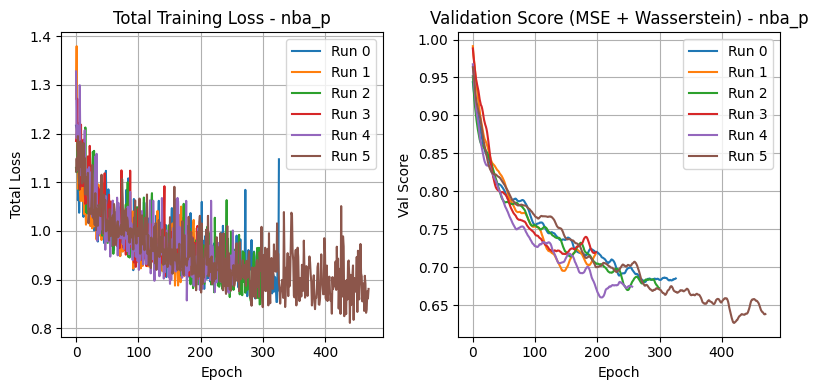

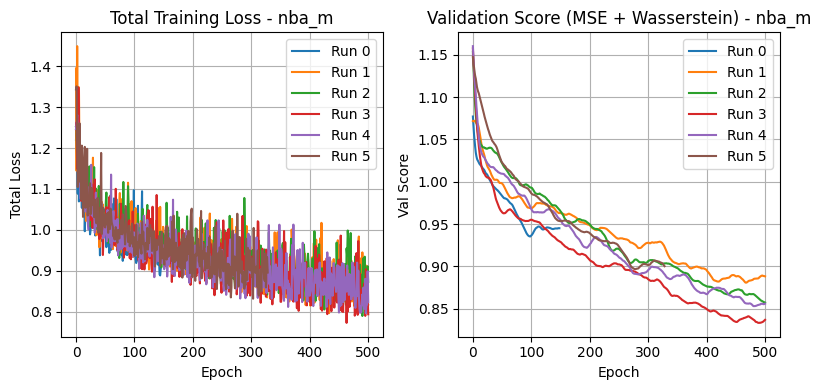

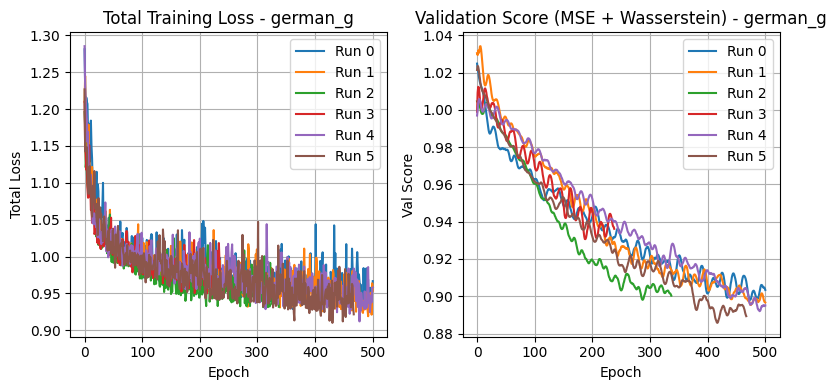

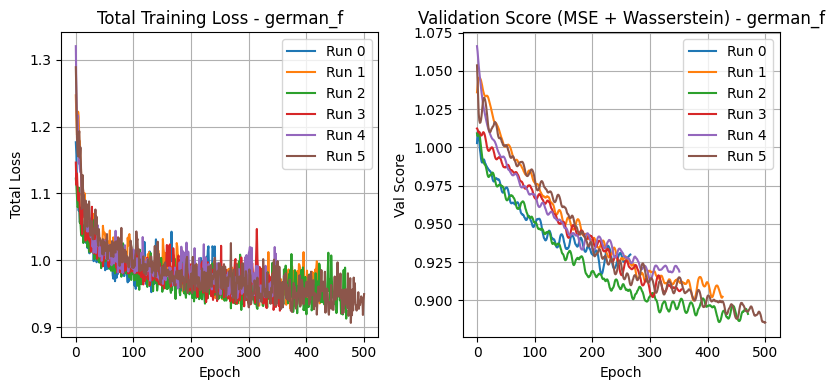

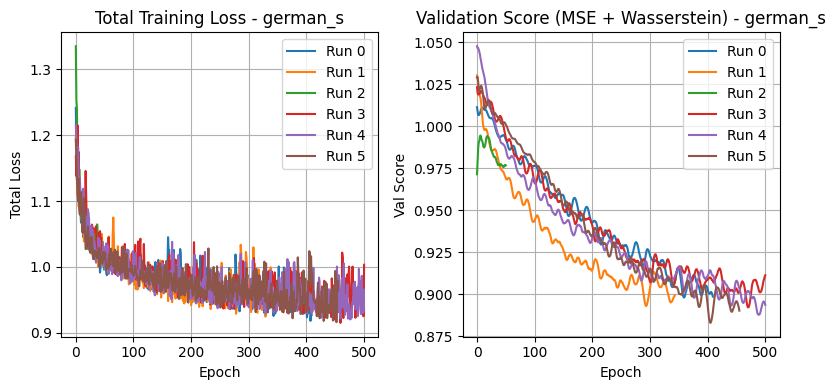

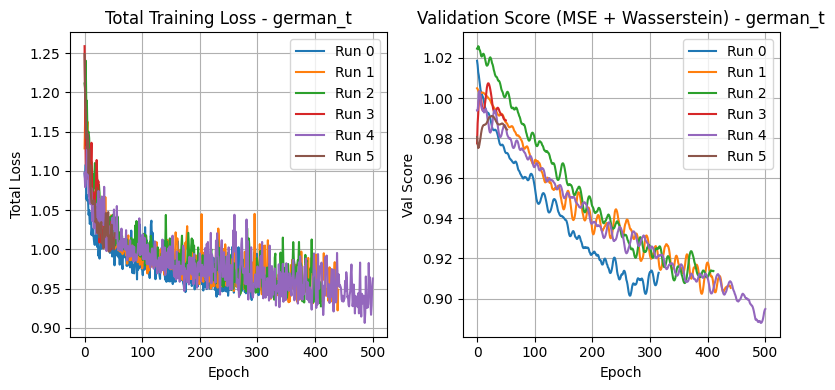

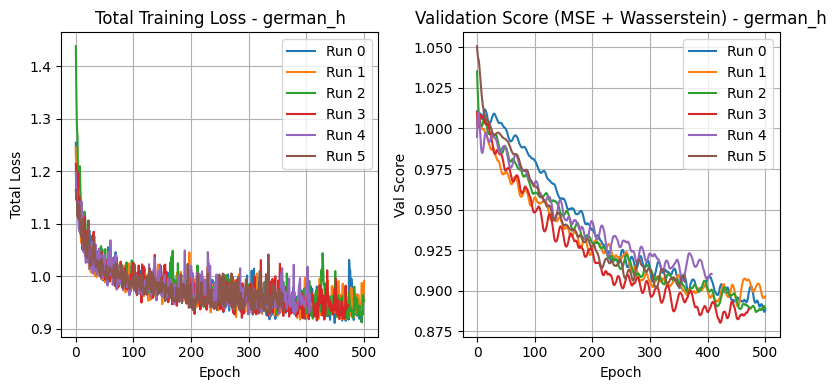

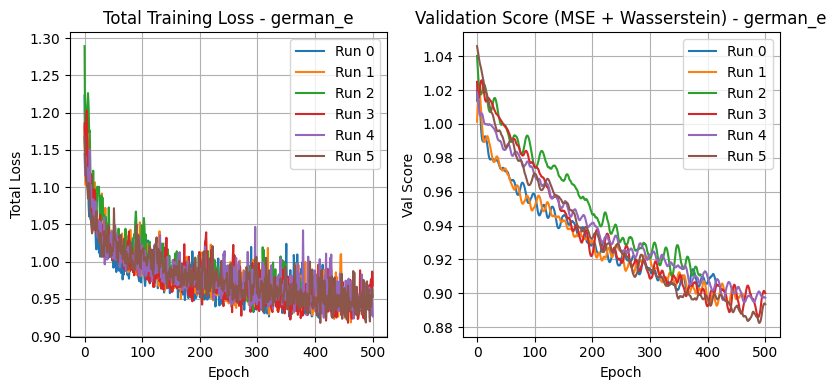

In [ ]:
# FnRGNN training 시각화
for dt in FnR_dt_list:
    plot_all_metrics(all_logs, dt)

### FnR Testing

In [9]:
# FnRGNN Testing
fnr_ts_results = {}
for ds in FnR_dt_list:
    print(f'\n>>> FmRGNN Evaluating Dataset: {ds}')
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    import json
    model_path = f'./model/FnRGNN_only/{dn}_md.pth'
    config_path = f"./logs/best_configs/{ds}_best_mse.json"
    # config_path = f"./logs/best_configs/{ds}_best_joint.json"

    with open(config_path, "r") as f:
        best_mse_result = json.load(f)
    params = best_mse_result['params']
    
    result = []
    for run in range(runs + 1):
        try:
            model = FnRGNN(
                nfeat=data.x.size(1),
                hidden_dim=params['hidden_dim'],
                dropout=params['dropout'],
                lm=params['lambda2'],
                gm=params['gamma'],
                ld=params['lambda_dist'],
                mmd_sample=500,
                lr=params['lr'],
                weight_decay=params['weight_decay']
            ).to(device)
            # model = FnRGNN(nfeat=data.x.size(1), hidden_dim=64, dropout=0.5, lm=3, ld=2, mmd_sample=500, lr=lr, weight_decay=weight_decay).to(device)
            
            state_dict = torch.load(model_path)
            model.load_state_dict(state_dict, strict=False)

            model.eval()
            with torch.no_grad():
                output, _ = model(data)
                
                y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
                mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(
                    output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu()
                )
                dist_test = group_distribution_metrics(
                    y_true[idx_test].cpu().numpy().squeeze(),
                    output[idx_test].cpu().numpy().squeeze(),
                    sensitive_attr[idx_test].cpu().numpy()
                )

            result.append([mse_test, mse_diff, mae_test, mae_diff, mean_diff, var_diff,
                            dist_test['wasserstein'], dist_test['js'], dist_test['kl'], dist_test['ks'], dist_test['cvm'], dist_test['tv']])
        
        except Exception as e:
            print(f"[FnRGNN_only - {ds} - Run {run}] 오류 발생: {e}")
            result.append(None)

    fnr_ts_results[ds] = result



>>> FmRGNN Evaluating Dataset: nba_p

>>> FmRGNN Evaluating Dataset: nba_m

>>> FmRGNN Evaluating Dataset: german_g

>>> FmRGNN Evaluating Dataset: german_f

>>> FmRGNN Evaluating Dataset: german_s

>>> FmRGNN Evaluating Dataset: german_t

>>> FmRGNN Evaluating Dataset: german_h

>>> FmRGNN Evaluating Dataset: german_e

>>> FmRGNN Evaluating Dataset: region_job_r

>>> FmRGNN Evaluating Dataset: region_job_2_r


In [16]:
# FnRGNN Results Check
metric_names = ['MSE', 'MSE Gap',  'MAE', 'MAE Gap', 'Mean Gap', 'Var Gap', 'WD', 'JSD', 'KL', 'KS', 'CVM', 'TV']

summary_table = {}
for dataset, runs_rst in fnr_ts_results.items():
    if runs_rst is None:
        continue
    valid_runs = [r for r in runs_rst if r is not None]
    if not valid_runs:
        continue

    arr = np.array(valid_runs)
    means = np.mean(arr, axis=0)
    stds = np.std(arr, axis=0)

    summary_table[dataset] = [
        f"{mean:.4f}" for mean, std in zip(means, stds)
    ]

df = pd.DataFrame(summary_table, index=metric_names)
selected_metrics = ['MSE', 'MAE', 'Mean Gap', 'Var Gap', 'WD']
filtered_df = df.loc[df.index.intersection(selected_metrics)]

print("=== 종합 성능 비교표 ===")
# keys = ['nba_m', 'german_g', 'region_job_r', 'region_job_2_r']
print(filtered_df.round(4))

=== 종합 성능 비교표 ===
           nba_p   nba_m german_g german_f german_s german_t german_h  \
MSE       0.2868  0.1495   0.6994   0.9124   0.7742   0.7098   0.8194   
MAE       0.4090  0.3024   0.6995   0.8254   0.7377   0.7169   0.7716   
Mean Gap  0.1171  0.0415   0.1421   0.0476   0.1135   0.1122   0.0646   
Var Gap   0.0765  0.1876   0.0730   0.0448   0.0692   0.0119   0.0539   
WD        0.0253  0.0070   0.0217   0.0015   0.0053   0.0460   0.0061   

         german_e region_job_r region_job_2_r  
MSE        0.7925       0.0622         0.1074  
MAE        0.7514       0.1829         0.2568  
Mean Gap   0.0825       0.0171         0.0647  
Var Gap    0.0358       0.0046         0.0200  
WD         0.0172       0.0057         0.0139  


### FnR Tuning

In [7]:
# hyperparameter tuninng
import optuna
import optuna.visualization as vis

def multiobjective_objective(trial, data):
    model = FnRGNN(
        nfeat=data.x.size(1),
        hidden_dim=trial.suggest_categorical("hidden_dim", [32, 64, 128]),
        dropout=trial.suggest_float("dropout", 0.2, 0.6),
        lm=trial.suggest_float("lambda2", 0.1, 5.0),  # 최소값 0.1로 제한
        gm=trial.suggest_float("gamma", 0.1, 5.0),
        ld=trial.suggest_float("lambda_dist", 0.1, 5.0),
        mmd_sample=500,
        lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        weight_decay=trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    ).to(device)


    best_val_mse = float("inf")
    best_mean_gap = float("inf")

    for epoch in range(30):
        model.optimize(data)
        model.eval()
        with torch.no_grad():
            output, _ = model(data)
            y_true = data.y[data.idx_val].cpu()
            y_pred = output[data.idx_val].cpu()

            val_mse = mean_squared_error(y_true, y_pred)
            _, _, mean_gap, _ = fair_metric_regression(y_pred, y_true, data.sensitive_attr[data.idx_val].cpu())

            best_val_mse = min(best_val_mse, val_mse)
            best_mean_gap = min(best_mean_gap, mean_gap)

    return best_val_mse, best_mean_gap

FnR_dt_list = [
    # 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e',
    # 'region_job_r', 'region_job_2_r',
    'region_job_g', 'region_job_2_g',
]

multi_results = {}
for ds in FnR_dt_list:
    print(f"\n Multi-objective tuning on {ds}")
    data = dt_dict[ds]['data']
    data = data.to(device)

    study = optuna.create_study(
        directions=["minimize", "minimize"],  # [MSE, fairness]
        study_name=f"fnr_{ds}_multi",
        sampler=optuna.samplers.NSGAIISampler()
    )
    study.optimize(lambda trial: multiobjective_objective(trial, data), n_trials=50)

    multi_results[ds] = study

save_dir = "./logs/best_configs"
os.makedirs(save_dir, exist_ok=True)

for ds, study in multi_results.items():
    best_configs = []

    for trial in study.best_trials:  # Pareto front에 있는 모든 trial
        best_configs.append({
            "val_mse": trial.values[0],
            "mean_gap": trial.values[1],
            "params": trial.params
        })

    # Step 1: 모든 MSE, GAP 값 추출
    mse_list = [t.values[0] for t in study.best_trials]
    gap_list = [t.values[1] for t in study.best_trials]

    min_mse, max_mse = min(mse_list), max(mse_list)
    min_gap, max_gap = min(gap_list), max(gap_list)

    # Step 2: 정규화 후 합산 score 계산
    def normalized_score(t):
        norm_mse = (t.values[0] - min_mse) / (max_mse - min_mse + 1e-8)
        norm_gap = (t.values[1] - min_gap) / (max_gap - min_gap + 1e-8)
        return norm_mse + norm_gap  # 또는 가중치 조절 가능

    # Step 3: 최소 score trial 선택
    best_joint_trial = min(study.best_trials, key=normalized_score)

    best_joint = {
        "val_mse": best_joint_trial.values[0],
        "mean_gap": best_joint_trial.values[1],
        "params": best_joint_trial.params
    }

    # 가장 MSE가 낮은 하나만 따로 저장
    best_mse_trial = min(study.best_trials, key=lambda t: t.values[0])
    best_single = {
        "val_mse": best_mse_trial.values[0],
        "mean_gap": best_mse_trial.values[1],
        "params": best_mse_trial.params
    }
    
    # 저장
    import json
    with open(f"{save_dir}/{ds}_pareto_all.json", "w") as f:
        json.dump(best_configs, f, indent=2)

    with open(f"{save_dir}/{ds}_best_mse.json", "w") as f:
        json.dump(best_single, f, indent=2)

    with open(f"{save_dir}/{ds}_best_joint.json", "w") as f:
        json.dump(best_joint, f, indent=2)

    print(f"Saved normalized joint-best config for {ds} at {save_dir}/{ds}_best_joint.json")


[I 2025-05-31 15:50:18,094] A new study created in memory with name: fnr_region_job_g_multi



 Multi-objective tuning on region_job_g


[I 2025-05-31 15:50:22,418] Trial 0 finished with values: [0.14418417641204115, 0.00034917891025543213] and parameters: {'hidden_dim': 64, 'dropout': 0.4410507259220512, 'lambda2': 1.503896320394899, 'gamma': 0.10961664262430311, 'lambda_dist': 1.255296309878722, 'lr': 0.006519151491644554, 'weight_decay': 2.4761158094704573e-05}.
[I 2025-05-31 15:50:25,975] Trial 1 finished with values: [0.17842050665567086, 5.2561983466148376e-05] and parameters: {'hidden_dim': 32, 'dropout': 0.3452873671177483, 'lambda2': 3.809536951496859, 'gamma': 4.1303683981567225, 'lambda_dist': 3.0552322642937715, 'lr': 0.0006182428505649535, 'weight_decay': 0.00024161995093976052}.
[I 2025-05-31 15:50:29,927] Trial 2 finished with values: [0.15983820388501607, 0.00035259127616882324] and parameters: {'hidden_dim': 64, 'dropout': 0.3746132433642325, 'lambda2': 4.801685686166901, 'gamma': 4.836543111443497, 'lambda_dist': 3.245872312305372, 'lr': 0.0007270666355501463, 'weight_decay': 0.00021967848030863283}.
[


 Multi-objective tuning on region_job_2_g


[I 2025-05-31 15:53:46,127] Trial 0 finished with values: [0.16878793047906607, 0.00028986483812332153] and parameters: {'hidden_dim': 128, 'dropout': 0.21148620698968468, 'lambda2': 1.7046193176859514, 'gamma': 4.796308746336664, 'lambda_dist': 2.3883934191731684, 'lr': 0.0002510175114599136, 'weight_decay': 6.552513690166797e-05}.
[I 2025-05-31 15:53:50,220] Trial 1 finished with values: [0.19483110942628964, 0.0005794614553451538] and parameters: {'hidden_dim': 128, 'dropout': 0.4261758804515627, 'lambda2': 2.8411247758900062, 'gamma': 3.6554439461407413, 'lambda_dist': 2.661380615196461, 'lr': 0.00016672363005408206, 'weight_decay': 6.111681640340701e-05}.
[I 2025-05-31 15:53:53,565] Trial 2 finished with values: [0.213359320147297, 3.50242480635643e-05] and parameters: {'hidden_dim': 64, 'dropout': 0.44257923465685345, 'lambda2': 1.271881477102372, 'gamma': 2.927453100493449, 'lambda_dist': 3.8944775227520716, 'lr': 0.0004044014609973962, 'weight_decay': 6.384883532598793e-05}.
[I

Saved normalized joint-best config for region_job_g at ./logs/best_configs/region_job_g_best_joint.json
Saved normalized joint-best config for region_job_2_g at ./logs/best_configs/region_job_2_g_best_joint.json


In [ ]:
# 시각화
for ds, study in multi_results.items():
    print(f"\n 시각화 - {ds}")

    # Parallel Coordinate Plot
    # MSE 중심 시각화
    fig1 = vis.plot_parallel_coordinate(study, target=lambda t: t.values[0], target_name="MSE")
    fig1.show()

    # Fairness 중심 시각화 (예: WD)
    fig2 = vis.plot_parallel_coordinate(study, target=lambda t: t.values[1], target_name="Wasserstein")
    fig2.show()

    # Contour Plot (MSE 기준)
    fig3 = vis.plot_contour(
    study,
    target=lambda t: t.values[0],
    target_name="Validation MSE"
    )
    fig3.show()

    fig4 = vis.plot_contour(
    study,
    target=lambda t: t.values[1],
    target_name="Wasserstein"
    )
    fig4.show()

    # Pareto Front Plot
    fig5 = vis.plot_pareto_front(study, target_names=["Validation MSE", "Mean Gap"])
    fig5.show()


### FnR ablation

In [17]:
# Ablation study
runs=5
epochs=100

cuda=torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
print(f"Using device: {device}")

seed=1127
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

lr=0.001
weight_decay=1e-5

ab_md_list = [
    # 'Vanilla', 
    'No_Edge', 'No_MMD', 'No_GWN', 
    # 'Full'
    ]
ab_dt_list = [
    # 'nba_p', 
    'nba_m', 'german_g', 
    # 'german_f', 'german_s', 'german_t', 'german_h', 'german_e',
    'region_job_r', 
    # 'region_job_2_r', 
    # 'region_job_g', 
    'region_job_2_g',
    ]

# train
for ds in ab_dt_list:
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    for md in ab_md_list:
        print(f'Train Ablation study ({md}) dataset from {ds}')
        os.makedirs(f'./model/ablation', exist_ok=True) 
        model_path = f'./model/ablation/{md}_{dn}_md.pth'
        config_path = f"./logs/best_configs/{ds}_best_mse.json"
        # config_path = f"./logs/best_configs/{ds}_best_joint.json"

        import json
        with open(config_path, "r") as f:
            best_mse_result = json.load(f)
        params = best_mse_result['params']
        
        for run in range(runs + 1):
            if md == 'Vanilla':
               model = GCNRegressor(in_dim=data.x.size(1), hidden_dim=64).to(device)
               optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
               criterion = torch.nn.MSELoss()
            else:
                if md == 'No_Edge':
                    edge, mmd, gwn = False, True, True
                elif md == 'No_MMD':
                    edge, mmd, gwn = True, False, True
                elif md  == 'No_GWN':
                    edge, mmd, gwn = True, True, False
                else:
                    edge, mmd, gwn = True, True, True
                    
                model = FnRGNN(
                    nfeat=data.x.size(1),
                    hidden_dim=params['hidden_dim'],
                    dropout=params['dropout'],
                    lm=params['lambda2'],
                    gm=params['gamma'],
                    ld=params['lambda_dist'],
                    mmd_sample=500,
                    lr=params['lr'],
                    weight_decay=params['weight_decay'],
                    use_mmd=mmd, use_gwn=gwn, use_edge_weight=edge
                ).to(device)

            best_score = float('inf')
            best_model_state = None
            patience_counter = 0

            for epoch in range(epochs + 1):
                if md == 'Vanilla':
                    model.train()
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output[data.idx_train].unsqueeze(1), data.y[data.idx_train].unsqueeze(1))
                    loss.backward()
                    optimizer.step()
                else:
                    loss_dict = model.optimize(data)
                    loss = loss_dict['total_loss']

                # validation
                model.eval()
                with torch.no_grad():
                    if md == 'Vanilla':
                        output = model(data)
                    else:
                        output, _ = model(data)
                    y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr
                    mse_val = mean_squared_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                    mae_val = mean_absolute_error(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze())
                    mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                    dist_val = group_distribution_metrics(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())
                    
                    if md == 'Vanilla' or md == 'No_GWN':
                        val_score = mse_val
                    else:
                        val_score = mse_val + dist_val['wasserstein']

                    if val_score < best_score:
                        best_score = val_score
                        best_model_state = copy.deepcopy(model.state_dict())
                        torch.save(best_model_state, model_path)
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f"[Early Stopping] Run {run}, Epoch {epoch} | Best Val Score: {best_score:.4f}")
                        break
                    
                    if epoch % 100 == 0:
                        print(f"[FnRGNN Only] Run {run}, Epoch {epoch} | Train Loss - Total: {loss:.4f}, ")
                        print(f"Val MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, "
                            f"MSE Diff: {mse_diff:.2f}, MAE Diff: {mae_diff:.2f}, "
                            f"Mean Diff: {mean_diff:.2f}, Var Diff: {var_diff:.2f}, "
                            f"Wasserstein Diff: {dist_val['wasserstein']:.2f}")                      


Using device: cuda:0
Train Ablation study (No_Edge) dataset from nba_m
[FnRGNN Only] Run 0, Epoch 0 | Train Loss - Total: 1.0956, 
Val MSE: 0.99, MAE: 0.84, MSE Diff: 0.10, MAE Diff: 0.00, Mean Diff: 0.00, Var Diff: 0.00, Wasserstein Diff: 0.01
[FnRGNN Only] Run 0, Epoch 100 | Train Loss - Total: 0.6591, 
Val MSE: 0.59, MAE: 0.62, MSE Diff: 0.10, MAE Diff: 0.00, Mean Diff: 0.03, Var Diff: 0.01, Wasserstein Diff: 0.09
[FnRGNN Only] Run 1, Epoch 0 | Train Loss - Total: 1.1125, 
Val MSE: 0.99, MAE: 0.85, MSE Diff: 0.04, MAE Diff: 0.00, Mean Diff: 0.00, Var Diff: 0.00, Wasserstein Diff: 0.00
[FnRGNN Only] Run 1, Epoch 100 | Train Loss - Total: 0.6950, 
Val MSE: 0.58, MAE: 0.62, MSE Diff: 0.12, MAE Diff: 0.00, Mean Diff: 0.06, Var Diff: 0.01, Wasserstein Diff: 0.06
[FnRGNN Only] Run 2, Epoch 0 | Train Loss - Total: 1.0838, 
Val MSE: 1.00, MAE: 0.85, MSE Diff: 0.01, MAE Diff: 0.00, Mean Diff: 0.01, Var Diff: 0.01, Wasserstein Diff: 0.04
[FnRGNN Only] Run 2, Epoch 100 | Train Loss - Total: 0.

In [19]:
# test
ab_md_list = [
    'Vanilla', 'No_Edge', 'No_MMD', 'No_GWN', 'Full'
    ]
ab_dt_list = [
    'nba_m', 'german_g', 
    'region_job_r', 
    'region_job_2_g',
    ]

ab_results = {}
for ds in ab_dt_list:
    print(f'\n>>> Evaluating Ablation Study Dataset: {ds}')
    data = dt_dict[ds]['data']
    data = data.to(device)

    cfg = dt_dict[ds]['cfg']
    dn = cfg['dn']

    for md in ab_md_list:
        print(f'Test {md} dataset from {ds}')
        if md == 'Vanilla':
            model_path = f'./model/GCNRegressor/{dn}_md.pth'
        elif md == 'Full':
            model_path = f'./model/FnRGNN_only/{dn}_md.pth'
        else:
            model_path = f'./model/ablation/{md}_{dn}_md.pth'

        import json
        config_path = f"./logs/best_configs/{ds}_best_mse.json"
        # config_path = f"./logs/best_configs/{ds}_best_joint.json"
        with open(config_path, "r") as f:
            best_mse_result = json.load(f)
        params = best_mse_result['params']
        
        if not os.path.exists(model_path):
            print(f"[{md} - {ds}] 모델 파일 없음: {model_path}")
            ts_results.setdefault(md, {})[ds] = None
            continue

        result = []
        for run in range(runs + 1):
            try:
                if md == 'Vanilla':
                    model = GCNRegressor(in_dim=data.x.size(1), hidden_dim=64).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                    criterion = torch.nn.MSELoss()
                else:
                    if md == 'No_Edge':
                        edge, mmd, gwn = False, True, True
                    elif md == 'No_MMD':
                        edge, mmd, gwn = True, False, True
                    elif md  == 'No_GWN':
                        edge, mmd, gwn = True, True, False
                    else:
                        edge, mmd, gwn = True, True, True

                    model = FnRGNN(
                        nfeat=data.x.size(1),
                        hidden_dim=params['hidden_dim'],
                        dropout=params['dropout'],
                        lm=params['lambda2'],
                        gm=params['gamma'],
                        ld=params['lambda_dist'],
                        mmd_sample=500,
                        lr=params['lr'],
                        weight_decay=params['weight_decay'],
                        use_mmd=mmd, use_gwn=gwn, use_edge_weight=edge
                    ).to(device)

                state_dict = torch.load(model_path)
                model.load_state_dict(state_dict, strict=False)

                model.eval()
                with torch.no_grad():
                    if md == 'Vanilla':
                        output = model(data)
                    else:
                        output, _ = model(data)

                    y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
                    mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                    mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                    mse_diff, mae_diff, mean_diff, var_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
                    dist_test = group_distribution_metrics(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

                result.append([mse_test, mae_test, mean_diff, var_diff, dist_test['wasserstein']])

            except Exception as e:
                print(f"[{md} - {ds} - Run {run}] 오류 발생: {e}")
                result.append(None)

        ab_results.setdefault(md, {})[ds] = result
  


>>> Evaluating Ablation Study Dataset: nba_m
Test Vanilla dataset from nba_m
Test No_Edge dataset from nba_m
Test No_MMD dataset from nba_m
Test No_GWN dataset from nba_m
Test Full dataset from nba_m

>>> Evaluating Ablation Study Dataset: german_g
Test Vanilla dataset from german_g
Test No_Edge dataset from german_g
Test No_MMD dataset from german_g
Test No_GWN dataset from german_g
Test Full dataset from german_g

>>> Evaluating Ablation Study Dataset: region_job_r
Test Vanilla dataset from region_job_r
Test No_Edge dataset from region_job_r
Test No_MMD dataset from region_job_r
Test No_GWN dataset from region_job_r
Test Full dataset from region_job_r

>>> Evaluating Ablation Study Dataset: region_job_2_g
Test Vanilla dataset from region_job_2_g
Test No_Edge dataset from region_job_2_g
Test No_MMD dataset from region_job_2_g
Test No_GWN dataset from region_job_2_g
Test Full dataset from region_job_2_g


In [21]:
# Ablation Results Check
metric_names = ['mse', 'mae', 'mean_diff', 'var_diff', 'wasserstein']

for md in ab_md_list:
    md_results = ab_results[md]

    summary_table = {}
    for dataset, runs_rst in md_results.items():
        if runs_rst is None:
            continue
        valid_runs = [r for r in runs_rst if r is not None]
        if not valid_runs:
            continue

        arr = np.array(valid_runs)
        means = np.mean(arr, axis=0)
        stds = np.std(arr, axis=0)
        summary_table[dataset] = [f"{mean:.4f}" for mean, std in zip(means, stds)]

    df_summary = pd.DataFrame(summary_table, index=metric_names)
    globals()[f'df_{md}_summary'] = df_summary

all_tables = {}
for ds in ab_dt_list:
    result_table = {}
    for md in [ 'Vanilla', 'No_Edge', 'No_MMD', 'No_GWN', 'Full']:
        df = globals().get(f'df_{md}_summary')
        if df is not None:
            if isinstance(df.index, pd.Index):
                filtered_df = df.loc[df.index.intersection(metric_names)]
                if ds in filtered_df.columns:
                    result_table[md] = filtered_df[ds]
    if result_table:
        df_combined = pd.DataFrame(result_table)
        df_combined.index.name = "Metric"
        all_tables[ds] = df_combined

        print(f'{ds} Results:')
        print(df_combined)


nba_m Results:
             Vanilla No_Edge  No_MMD  No_GWN    Full
Metric                                              
mse           5.3053  0.5787  0.1695  0.1119  0.1495
mae           1.2044  0.6147  0.3272  0.2570  0.3024
mean_diff     1.2781  0.0278  0.0025  0.1743  0.0415
var_diff     10.9108  0.1041  0.0824  0.0752  0.1876
wasserstein   1.0585  0.0321  0.0561  0.0182  0.0070
german_g Results:
            Vanilla No_Edge  No_MMD  No_GWN    Full
Metric                                             
mse          1.4856  0.8654  0.8072  0.7984  0.6994
mae          0.9976  0.7931  0.7550  0.7263  0.6995
mean_diff    0.3226  0.0624  0.1511  0.1098  0.1421
var_diff     0.0046  0.0818  0.0349  0.0113  0.0730
wasserstein  0.0372  0.0284  0.0524  0.0167  0.0217
region_job_r Results:
            Vanilla No_Edge  No_MMD  No_GWN    Full
Metric                                             
mse          0.4676  0.4646  0.0846  0.0798  0.0622
mae          0.5169  0.5507  0.2208  0.2128  0.1829
me

In [25]:
# latex 테이블 생성
df_latex = all_tables['region_job_2_g'].reset_index()
df_latex['Metric'] = df_latex['Metric'].replace({'mse': 'MSE', 'mae': 'MAE', 'mean_diff': 'Mean Gap', 'var_diff': 'Var Gap', 'wasserstein': 'WD'})
df_latex = df_latex.iloc[[0, 4], ]
print(df_latex.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{llllll}
\toprule
Metric & Vanilla & No_Edge & No_MMD & No_GWN & Full \\
\midrule
MSE & 0.4837 & 0.4417 & 0.0789 & 0.0676 & 0.0511 \\
WD & 0.0181 & 0.0123 & 0.0036 & 0.0025 & 0.0018 \\
\bottomrule
\end{tabular}



In [ ]:
# 모든 값을 숫자형(float)으로 변환 (변환 불가한 값은 NaN 처리)
nba_1 = all_tables['nba_m'].apply(pd.to_numeric, errors='coerce')
nba_2 = all_tables['nba_p'].apply(pd.to_numeric, errors='coerce')
# nba_3 = all_tables['german_s'].apply(pd.to_numeric, errors='coerce')
# nba_4 = all_tables['german_t'].apply(pd.to_numeric, errors='coerce')
# nba_5 = all_tables['german_g'].apply(pd.to_numeric, errors='coerce')
# nba_6 = all_tables['german_h'].apply(pd.to_numeric, errors='coerce')

# 두 DataFrame 더하기
combined_df = nba_1 + nba_2 
# + nba_3 + nba_4 + nba_5 + nba_6 

# 평균 계산
average_df = combined_df / 2

# 결과 출력
print(average_df)


In [ ]:
# latex 테이블 생성
df_latex = average_df.reset_index()
df_latex['Metric'] = df_latex['Metric'].replace({'mse': 'MSE', 'mae': 'MAE', 'mean_diff': 'Mean Gap', 'var_diff': 'Var Gap', 'wasserstein': 'WD'})
print(df_latex.to_latex(index=False, float_format="%.4f"))